# Collect Images

In [1]:
import cv2

import uuid
import imutils

In [2]:
# cam = cv2.VideoCapture(0)

# while True:
#     ret, frame = cam.read()
#     if not ret:
#         print("failed to grab frame")
#         break
#     frame = imutils.resize(frame, width=320)
#     cv2.imshow('frame', frame)

#     k = cv2.waitKey(1)
#     if k%256 == 27:
#         # ESC pressed
#         print("Escape hit, closing...")
#         break
#     elif k%256 == 32:
#         # SPACE pressed
#         imgname = './Images/More/{}.jpg'.format(str(uuid.uuid1()))
#         cv2.imwrite(imgname, frame)
#         print("{} written!".format(imgname))
#         img_counter += 1

In [3]:
# cap = cv2.VideoCapture(0)

In [4]:
# while True: 
#     ret, frame = cap.read()
#     imgname = './Images/Test/No Mask/{}.jpg'.format(str(uuid.uuid1()))
#     frame = imutils.resize(frame, width=320)
#     cv2.imwrite(imgname, frame)
#     cv2.imshow('frame', frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

In [5]:
# cam.release()
# cam.destroyAllWindows()

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

all_images = []
for subdir, dirs, files in os.walk('./Images/Train'):
    for file in files:
        file_name = os.path.join(subdir, file)
        if file_name.endswith('.jpg'):
            img = cv2.imread(file_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            all_images = all_images + [img.flatten()]

all_images = np.array(all_images)
all_images.shape

(2054, 172800)

In [7]:
X = all_images - all_images.mean(0)
xxt = np.dot(X, X.T) 

eigenValues, eigenVectors = np.linalg.eig(xxt/(all_images.shape[0] - 1))

idx = eigenValues.argsort()[::-1] 
eigvals = eigenValues[idx]
eigvectors = eigenVectors[:,idx]

temp = (1/(((all_images.shape[0] - 1)*eigvals) ** 0.5))*(np.dot((X.T), eigvectors))
eigvecs = temp[:, :(all_images.shape[0] - 1)]

eigvecs = eigvecs.T
eigvecs

array([[-9.21892384e-04, -8.07749206e-04, -8.49647225e-04, ...,
         3.51162445e-03,  6.53150437e-03,  6.29339612e-03],
       [ 1.88878701e-04,  1.36687782e-04,  1.14501190e-04, ...,
         8.50932849e-04,  3.99411337e-04,  2.45389781e-04],
       [ 1.27459078e-04,  1.54970321e-04,  1.33345447e-04, ...,
        -6.60483740e-03, -7.35766409e-03, -6.39770522e-03],
       ...,
       [ 2.53291565e-03,  6.77939001e-03,  3.87378090e-03, ...,
         5.22331977e-04, -1.38652954e-03,  8.51770815e-04],
       [ 1.96288457e-03, -2.79348473e-05, -3.01510556e-04, ...,
        -3.75900799e-04,  1.31425922e-03,  2.73422997e-03],
       [-2.91256950e-03, -1.94797356e-03, -3.12319526e-03, ...,
         1.49478628e-03, -1.13018495e-03,  2.13762691e-03]])

In [8]:
eigvecs_norm = np.round(((eigvecs - np.nanmin(eigvecs))/(np.nanmax(eigvecs) - np.nanmin(eigvecs)))*255).astype(int)

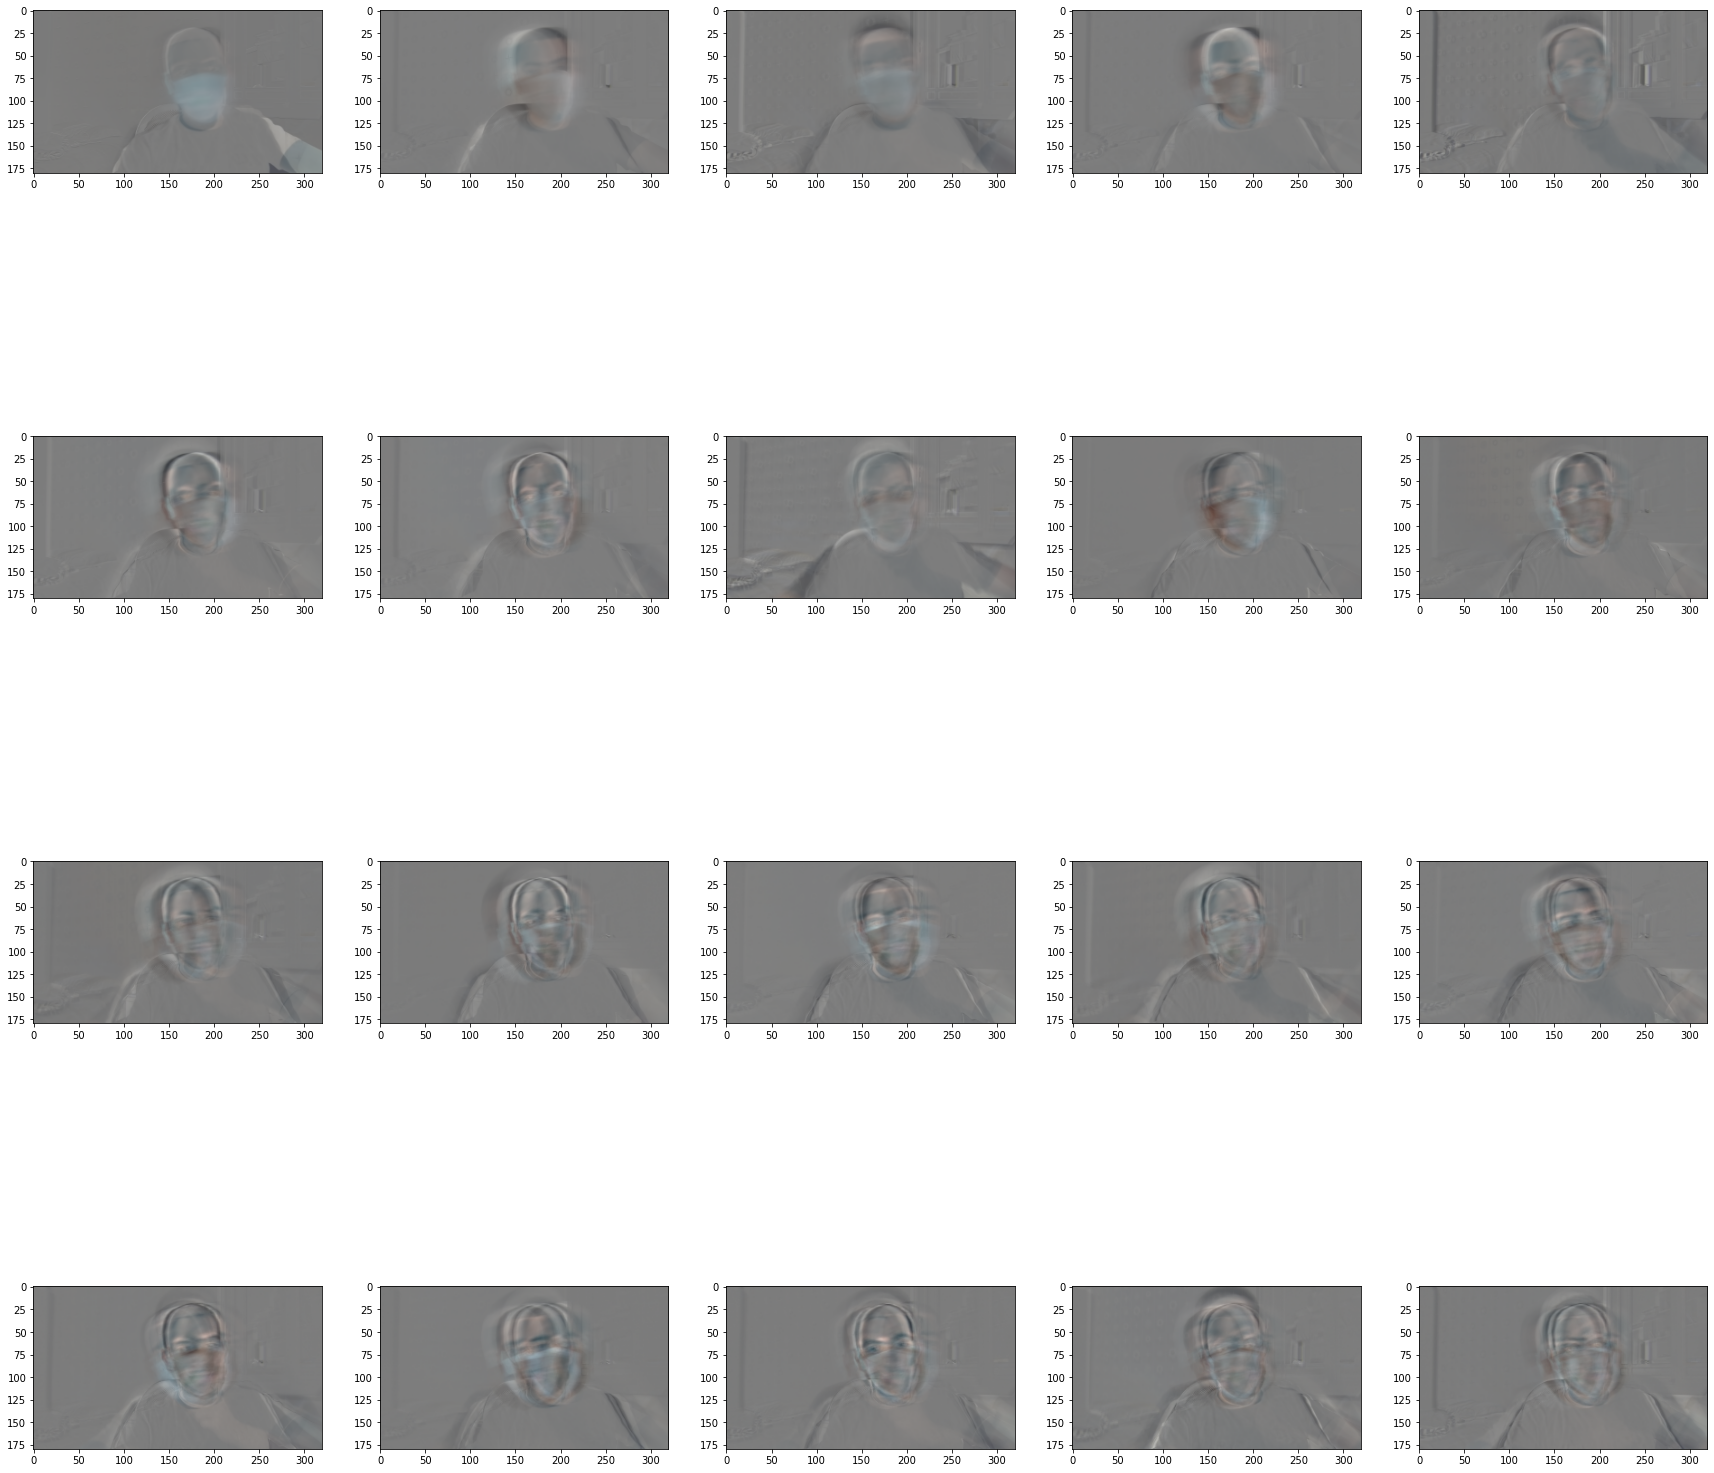

In [35]:
from matplotlib import rcParams

fig, ax = plt.subplots(4,5)

rcParams['figure.figsize'] = 30, 30

for i in range(4):
    for j in range(5):
        ax[i][j].imshow(eigvecs_norm[5*i+j].reshape(180,320,3))

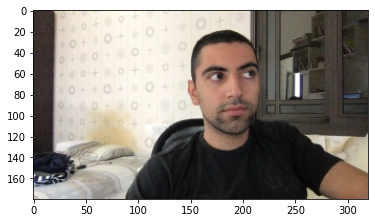

In [10]:
img0 = all_images[0]
rcParams['figure.figsize'] = 6 ,6

plt.imshow(img0.reshape(180,320,3))

In [11]:
n_eigfaces = 1
weights = np.dot(img0, eigvecs[:n_eigfaces].T)

In [12]:
weights[0]

-12189.641848166215

In [13]:
pca_img = np.zeros(img0.size)
for i in range(n_eigfaces):
    pca_img = pca_img + weights[i] * eigvecs[i]
    
pca_img

array([ 11.23753799,   9.84617352,  10.35689537, ..., -42.80544433,
       -79.61669895, -76.71424474])

In [14]:
pca_img = np.round(((pca_img - np.nanmin(pca_img))/(np.nanmax(pca_img) - np.nanmin(pca_img)))*255).astype(int)
pca_img

array([131, 130, 131, ...,  94,  68,  70])

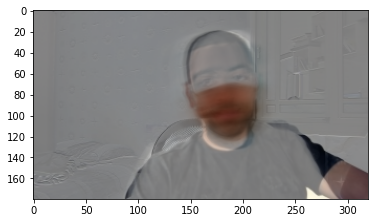

In [15]:
plt.imshow(pca_img.reshape(180, 320, 3))

## Load images with target (same face: yes/no)

In [16]:
all_images_weights = []
max_n_eigs = 50

for subdir, dirs, files in os.walk('Images/Predictors_images'):
    for file in files:
        file_name = os.path.join(subdir, file)
        if file_name.endswith('.jpg'):
            img = cv2.imread(file_name)
            img_flatten = img.flatten()
            weights = np.dot(img_flatten, eigvecs[:max_n_eigs].T)
            
            all_images_weights = all_images_weights + [(file_name, weights)]



In [17]:
pairs_target_dict = dict()

for t1 in all_images_weights:
    for t2 in all_images_weights:
        if t1[0] != t2[0]:
            if (t2[0], t1[0]) in pairs_target_dict:
                continue
            
            dict_to_store = dict()
            dict_to_store['image1'] = t1[1]
            dict_to_store['image2'] = t2[1]
            subdir1 = os.path.join(*t1[0].split('/')[:-1])
            subdir2 = os.path.join(*t2[0].split('/')[:-1])
            if subdir1 == subdir2:
                dict_to_store['target'] = True
            else:
                dict_to_store['target'] = False
            pairs_target_dict[(t1[0], t2[0])] = dict_to_store

In [18]:
import pandas as pd

max_n_eigvals = 50

max_acc = 0
i_max_acc = -1
t_max_acc = -1
for i in range(max_n_eigvals):
    distances = []
    targets = []
    for key, value in pairs_target_dict.items():        
        distances = distances + [np.linalg.norm(value['image1'][:i] - value['image2'][:i])]
        targets = targets + [value['target']]
        
    df = pd.DataFrame({'distance': distances, 'target': targets})
    df_sorted = df.sort_values(by=['distance'])
    df_sorted['prediction'] = False
    
    nrows = df_sorted.shape[0]
    for j in range(nrows):
        t = df_sorted.iloc[j]['distance']
        df_sorted['prediction'] = False
        df_sorted.loc[df_sorted['distance'] < t, 'prediction'] = True
        TP = (df_sorted['target'] & df_sorted['prediction']).sum()
        TN = (~(df_sorted['target'] | df_sorted['prediction'])).sum()
        FP = (~df_sorted['target'] & df_sorted['prediction']).sum()
        FN = (df_sorted['target'] & ~df_sorted['prediction']).sum()
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        acc = (TP + TN) / (TP + FP + TN + FN)
        if acc > max_acc:
            max_acc = acc
            i_max_acc = i
            t_max_acc = t

In [19]:
i_max_acc

1

In [20]:
t_max_acc

2293.748466358793

In [21]:
max_acc

1.0

In [22]:
distances = []
targets = []

for key, value in pairs_target_dict.items():        
        distances = distances + [np.linalg.norm(value['image1'][:i_max_acc] - value['image2'][:i_max_acc])]
        targets = targets + [value['target']]

In [23]:
df = pd.DataFrame({'distance': distances, 'target': targets})

df.head()

,distance,target
0,28.009382,True
1,49.536081,True
2,146.566887,True
3,34.381035,True
4,455.964159,True


In [24]:
df_sorted = df.sort_values(by=['distance'])
df_sorted['prediction'] = False
df_sorted.head()

,distance,target,prediction
168,2.562778,True,False
165,4.514312,True,False
21,6.371654,True,False
186,7.077090,True,False
173,10.194074,True,False


In [25]:
tpr_fpr_df = pd.DataFrame(columns = ['tpr', 'fpr'])

nrows = df_sorted.shape[0]
for i in range(nrows):
    t = df_sorted.iloc[i]['distance']
    df_sorted['prediction'] = False
    df_sorted.loc[df_sorted['distance'] < t, 'prediction'] = True
    TP = (df_sorted['target'] & df_sorted['prediction']).sum()
    TN = (~(df_sorted['target'] | df_sorted['prediction'])).sum()
    FP = (~df_sorted['target'] & df_sorted['prediction']).sum()
    FN = (df_sorted['target'] & ~df_sorted['prediction']).sum()
    print('TPR for t={} is {}'.format(t, TPR))
    print('FPR is {}'.format(FPR))
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    tpr_fpr_df.loc[i] = [TPR, FPR]

TPR for t=2.56277822361335 is 1.0
FPR is 0.99
TPR for t=4.514311962171632 is 0.0
FPR is 0.0
TPR for t=6.371653609925488 is 0.011111111111111112
FPR is 0.0
TPR for t=7.077090185784982 is 0.022222222222222223
FPR is 0.0
TPR for t=10.19407356818283 is 0.03333333333333333
FPR is 0.0
TPR for t=16.447817613208827 is 0.044444444444444446
FPR is 0.0
TPR for t=23.395371067074848 is 0.05555555555555555
FPR is 0.0
TPR for t=24.37687764527618 is 0.06666666666666667
FPR is 0.0
TPR for t=26.641891181391657 is 0.07777777777777778
FPR is 0.0
TPR for t=28.00938177345779 is 0.08888888888888889
FPR is 0.0
TPR for t=33.58944463525768 is 0.1
FPR is 0.0
TPR for t=34.38103538338328 is 0.1111111111111111
FPR is 0.0
TPR for t=42.162949711014335 is 0.12222222222222222
FPR is 0.0
TPR for t=48.53460332093982 is 0.13333333333333333
FPR is 0.0
TPR for t=48.75738208869461 is 0.14444444444444443
FPR is 0.0
TPR for t=49.53608090738089 is 0.15555555555555556
FPR is 0.0
TPR for t=50.037262248466504 is 0.1666666666666666

TPR for t=3789.826977640465 is 1.0
FPR is 0.67
TPR for t=3814.9861809025697 is 1.0
FPR is 0.68
TPR for t=3839.363058547846 is 1.0
FPR is 0.69
TPR for t=3912.0169869520905 is 1.0
FPR is 0.7
TPR for t=3936.3938645973667 is 1.0
FPR is 0.71
TPR for t=3959.3450838873423 is 1.0
FPR is 0.72
TPR for t=3963.859395849514 is 1.0
FPR is 0.73
TPR for t=3966.4221740731273 is 1.0
FPR is 0.74
TPR for t=4015.179556161822 is 1.0
FPR is 0.75
TPR for t=4031.6273737750307 is 1.0
FPR is 0.76
TPR for t=4041.8214473432135 is 1.0
FPR is 0.77
TPR for t=4065.2168184102884 is 1.0
FPR is 0.78
TPR for t=4114.966428093799 is 1.0
FPR is 0.79
TPR for t=4119.48074005597 is 1.0
FPR is 0.8
TPR for t=4122.043518279584 is 1.0
FPR is 0.81
TPR for t=4170.800900368278 is 1.0
FPR is 0.82
TPR for t=4187.248717981487 is 1.0
FPR is 0.83
TPR for t=4197.44279154967 is 1.0
FPR is 0.84
TPR for t=4220.838162616745 is 1.0
FPR is 0.85
TPR for t=4221.414259099787 is 1.0
FPR is 0.86
TPR for t=4245.791136745063 is 1.0
FPR is 0.87
TPR for t

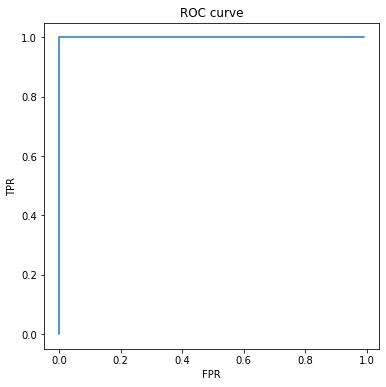

In [26]:
tpr_fpr_df.plot(x='fpr', y='tpr')

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend().remove()
plt.show()

In [27]:
df_sorted['prediction'] = False
df_sorted.loc[df_sorted['distance'] < t_max_acc, 'prediction'] = True
TP = (df_sorted['target'] & df_sorted['prediction']).sum()
TN = (~(df_sorted['target'] | df_sorted['prediction'])).sum()
FP = (~df_sorted['target'] & df_sorted['prediction']).sum()
FN = (df_sorted['target'] & ~df_sorted['prediction']).sum()
precision = TP / (TP + FP)
print(precision)

1.0


# Predict

In [28]:
target_idx_in_path = 2

#Mask - Positive
#No Mask - Negative
TP = 0
FN = 0
TN = 0
FP = 0

for subdir, dirs, files in os.walk('Images/Test/Mask'):
    for file in files:
        file_name = os.path.join(subdir, file)
        if file_name.endswith('.jpg'):
            img_to_predict = cv2.imread(file_name).flatten()
            weights_of_image = np.dot(img_to_predict, eigvecs[:i_max_acc].T)
            no_mask_distances = 0
            mask_distances = 0
            for predictor in all_images_weights:
                target = predictor[0].split('/')[target_idx_in_path]
                distance = np.linalg.norm(predictor[1][:i_max_acc] - weights_of_image)
                if(target == 'No Mask'):
                    no_mask_distances = no_mask_distances + distance
                else:
                    mask_distances = mask_distances + distance
            if mask_distances < no_mask_distances:
                TP = TP + 1
            else:
                FN = FN + 1
                
for subdir, dirs, files in os.walk('Images/Test/No Mask'):
    for file in files:
        file_name = os.path.join(subdir, file)
        if file_name.endswith('.jpg'):
            img_to_predict = cv2.imread(file_name).flatten()
            weights_of_image = np.dot(img_to_predict, eigvecs[:i_max_acc].T)
            no_mask_distances = 0
            mask_distances = 0
            for predictor in all_images_weights:
                target = predictor[0].split('/')[target_idx_in_path]
                distance = np.linalg.norm(predictor[1][:i_max_acc] - weights_of_image)
                if(target == 'No Mask'):
                    no_mask_distances = no_mask_distances + distance
                else:
                    mask_distances = mask_distances + distance
            if mask_distances < no_mask_distances:
                FP = FP + 1
            else:
                TN = TN + 1
        


In [29]:
TP

209

In [30]:
FN

0

In [31]:
TN

99

In [32]:
FP

0

In [33]:
file_name = 'Images/Test/Mask/44dbd9ea-19d8-11eb-867f-acde48001122.jpg'
img_to_predict = cv2.imread(file_name).flatten()
weights_of_image = np.dot(img_to_predict, eigvecs[:i_max_acc].T)
no_mask_distances = 0
mask_distances = 0
for predictor in all_images_weights:
    target = predictor[0].split('/')[target_idx_in_path]
    distance = np.linalg.norm(predictor[1][:i_max_acc] - weights_of_image)
    if(target == 'No Mask'):
        no_mask_distances = no_mask_distances + distance
    else:
        mask_distances = mask_distances + distance
if mask_distances < no_mask_distances:
    print('Mask Image')
else:
    print('No Mask Image')

Mask Image
